<h1><center> Facial Emotion Recognition - Live Prediction</center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream. 

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters 
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

Versions used :

In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

### Visualization ###
from ggplot import *
import time
from sklearn.manifold import TSNE

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


# III. Import datas

In [2]:
path = '/Users/maelfabien/filrouge_pole_emploi/Video/'
local_path = '/Users/maelfabien/Desktop/LocalDB/Videos/'

In [3]:
X_train = np.load(local_path + "X_train.npy")
X_test = np.load(local_path + "X_test.npy")
y_train = np.load(local_path + "y_train.npy")
y_test = np.load(local_path + "y_test.npy")

In [4]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [78]:
nRows, nCols, nDims

(48, 48, 1)

# IV. Detect Faces

First of all, we need to detect the faces inside an image. This will allow us to :
- focus on the region of the face
- stop the prediction if no face is recognized.

To do so, we use OpenCV faceCascade classifier. Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

The term "Cascade" comes from the fact that when a window is explored and no face edge is identified, the region is left apart and we move on to the next one using Adaboost classifier. This makes the overall process very efficient.

In [5]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [6]:
#Extraire les features faciales
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        #Region dans laquelle la face est détectée
        x, y, w, h = det
        #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transforme l'image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom sur la face extraite
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

Initial picture :

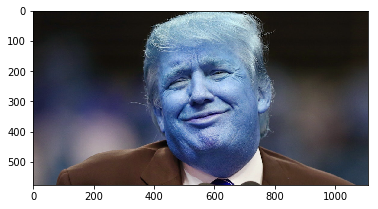

In [7]:
trump = '/Users/maelfabien/MER/Video/Test_Images/trump.jpg'
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

Extracted face :

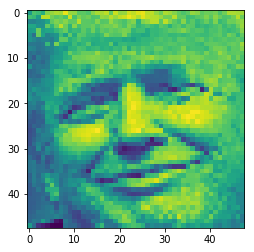

In [8]:
face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

# V. Load model and visualize layers

In [9]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [10]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [11]:
def exit_flow(x) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(7, activation='softmax', activity_regularizer=l2(0.001))(x)
    
    return x

In [12]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = Model(inputs, outputs)

In [14]:
model.load_weights(local_path + 'savedmodels/xception_2.hdf5')

In [79]:
model.save(local_path +'final_xception.h5')  # creates a HDF5 file 'my_model.h5'

In [83]:
# returns a compiled model
# identical to the previous one
from tensorflow.keras.models import load_model
model = load_model(local_path +'final_xception.h5')

In [ ]:
model.

# VI. Visualize layers

In [48]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [49]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

In [50]:
trump = '/Users/maelfabien/MER/Video/Test_Images/trump.jpg'
trump_face = cv2.imread(trump)
face = extract_face_features(detect_face(trump_face))[0]

to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

InvalidArgumentError: input_1_1:0 is both fed and fetched.

In [51]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'activations' is not defined

# VII. Making a prediction on an image

In [52]:
hanks = '/Users/maelfabien/MER/Video/Test_Images/hanks_vs.jpg'
hanks_face = cv2.imread(hanks)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1a496852b0>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1398, in __del__
    self._session._session, self._handle, status)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140696414133040


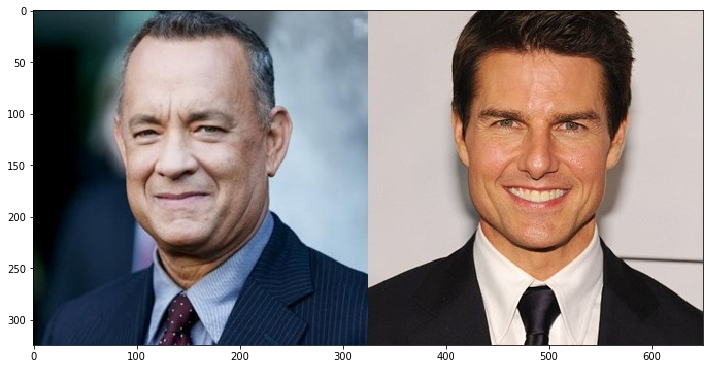

In [53]:
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(hanks_face, cv2.COLOR_BGR2RGB))

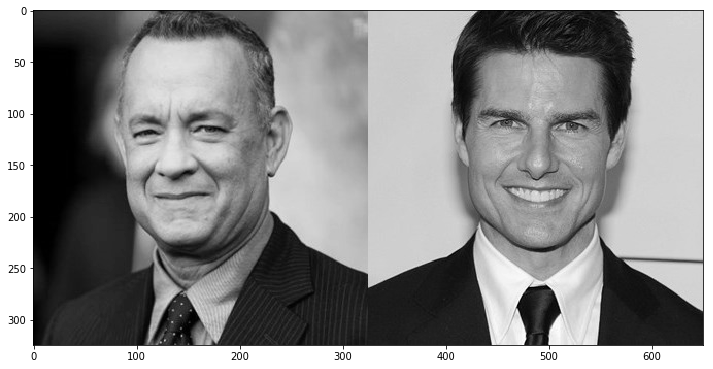

In [54]:
plt.figure(figsize=(12,12))
plt.imshow(detect_face(hanks_face)[0], 'gray')
plt.show()

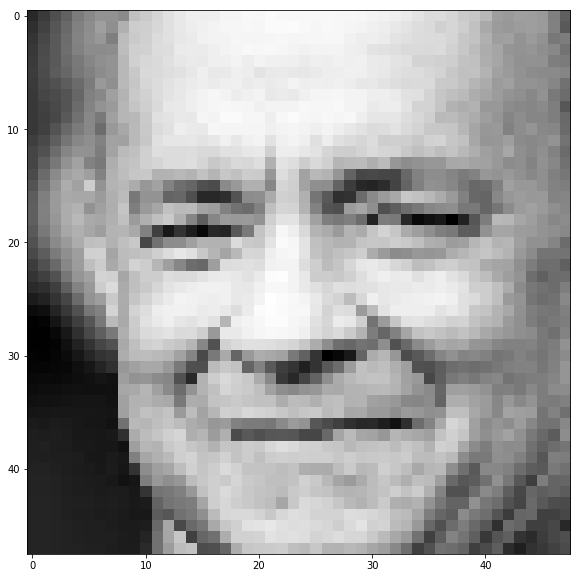

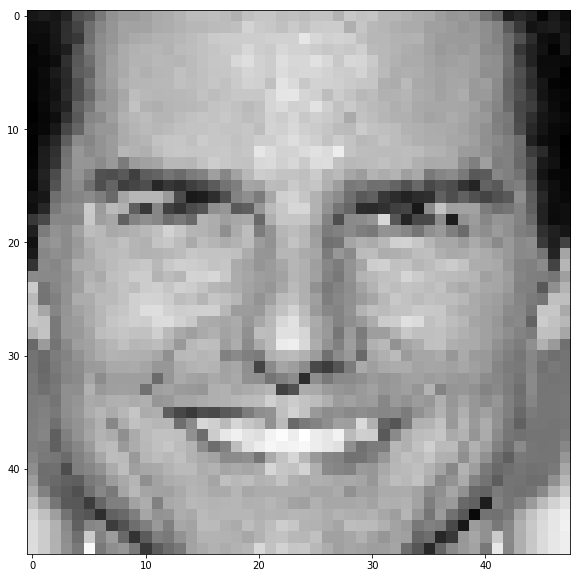

In [55]:
for face in extract_face_features(detect_face(hanks_face)) :
    plt.figure(figsize=(10,10))
    plt.imshow(face, 'gray')
    plt.show()

In [56]:
for face in extract_face_features(detect_face(hanks_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)

3
3


This corresponds to the Happy Labels which is a good prediction.

# IX. Enhanced Visualization

This basic step is now woring properly and results are quite satisfying. There are lots of sources of improvements we'll try to implement over time :
- add features from manually selected filters (e.g Gabor filters)
- take into account the frequency of eye blinks
- take into account the symetry of the keypoints on a face
- display all the keypoints of the face
- align the face by scaling of the facial features
- add emojis translating the emotion

## a. Frequency of eye blink

In [15]:
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [16]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("/Users/maelfabien/Desktop/LocalDB/Videos/landmarks/shape_predictor_68_face_landmarks.dat")

In [17]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

## b. Detect Keypoints to plot them

In [18]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

## c. Face Alignment

In [25]:
desiredLeftEye=(0.35, 0.35)

def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
        
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

## d. Final Prediction

In [86]:
#Lancer la capture video
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)
    #gray, detected_faces, coord = detect_face(frame)
    try : 
        for (i, rect) in enumerate(rects):

            shape = predictor_landmarks(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # Identify face coordinates
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            face = gray[y:y+h,x:x+w]

            #Zoom on extracted face
            face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))

            #Cast type float
            face = face.astype(np.float32)

            #Scale
            face /= float(face.max())
            face = np.reshape(face.flatten(), (1, 48, 48, 1))

            #Make Prediction
            prediction = model.predict(face)
            prediction_result = np.argmax(prediction)

            # Rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            for (j, k) in shape:
                cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

            # 12. Add prediction probabilities
            cv2.putText(frame, "----------------",(40,100 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Emotional report : Face #" + str(i+1),(40,120 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)

            # draw extracted face in the top right corner
            #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

            # 13. Annotate main image with a label
            if prediction_result == 0 :
                cv2.putText(frame, "Angry",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 1 :
                cv2.putText(frame, "Disgust",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 2 :
                cv2.putText(frame, "Fear",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 3 :
                cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 4 :
                cv2.putText(frame, "Sad",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 5 :
                cv2.putText(frame, "Surprise",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else :
                cv2.putText(frame, "Neutral",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # 5. Eye Detection and Blink Count
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]

            # Compute Eye Aspect Ratio
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0

            # And plot its contours
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # Compute total blinks and frequency
            #if ear < thresh:
                #flag += 1
                #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            #cv2.putText(frame, "Total blinks : " + str(flag), (40, 280 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            # 6. Detect Nose
            nose = shape[nStart:nEnd]
            noseHull = cv2.convexHull(nose)
            cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

            # 7. Detect Mouth
            mouth = shape[mStart:mEnd]
            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)

            # 8. Detect Jaw
            jaw = shape[jStart:jEnd]
            jawHull = cv2.convexHull(jaw)
            cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)

            # 9. Detect Eyebrows
            ebr = shape[ebrStart:ebrEnd]
            ebrHull = cv2.convexHull(ebr)
            cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
            ebl = shape[eblStart:eblEnd]
            eblHull = cv2.convexHull(ebl)
            cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)

        cv2.putText(frame,'Number of Faces : ' + str(len(rects)),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        cv2.imshow('Video', frame)
    except :
        pass
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of 

KeyboardInterrupt: 

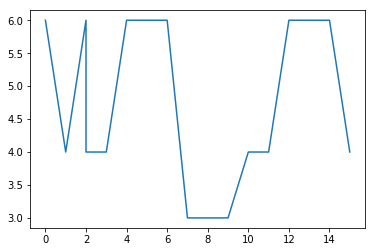

In [368]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i) :
    graph_data = emotion
    xs = []
    ys = []
    for emo in graph_data:
        xs.append(emo[0])
        ys.append(emo[1])
    ax1.clear()
    ax1.plot(xs,ys)

ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

# X. Sources

- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450